## Baseline
This notebook implments a baseline model, which shows you how to handle the data and to provide a first very simple solution to the problem. You may re-use and modify any part of this notebook.

In [1]:
import os
import csv
import torch
import pickle
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from ipywidgets import FloatProgress
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torch.nn.utils import clip_grad_norm_
from sklearn.metrics import accuracy_score, f1_score
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from torchmetrics import AUROC, F1Score
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

In [2]:
data_dir = 'kaggle_data'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used : {device}')

Device used : cpu


## Data Visualisation

In [3]:
train_df = pd.read_csv(os.path.join(data_dir, f'train_y.csv'))

In [4]:
train_df.columns

Index(['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions',
       'black', 'white', 'identity_any', 'severe_toxicity', 'obscene',
       'threat', 'insult', 'identity_attack', 'sexual_explicit', 'y',
       'from_source_domain'],
      dtype='object')

---------------------------
Number of comments: 269038
Number of toxic comments: 30515
---------------------------


<Axes: >

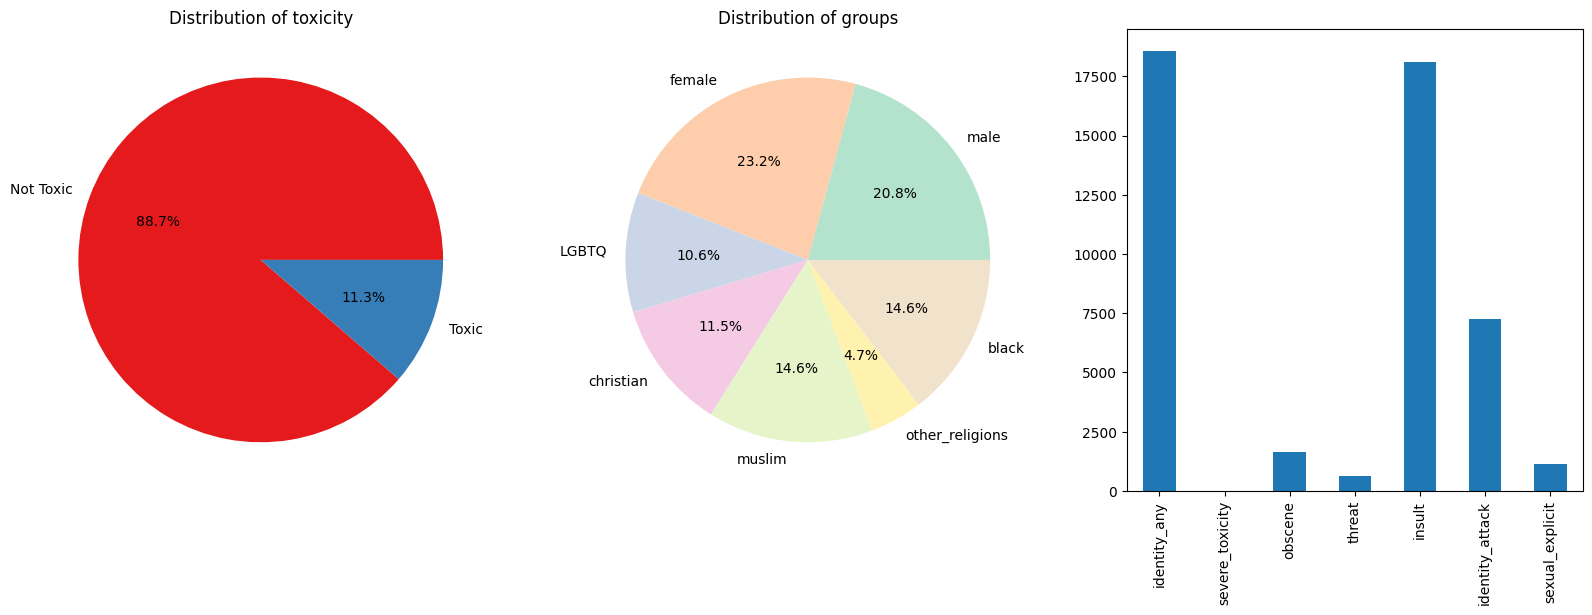

In [5]:
toxic_comment = train_df[train_df['y']==1]

print('---------------------------')
print(f'Number of comments: {len(train_df)}')
print(f'Number of toxic comments: {len(toxic_comment)}')
print('---------------------------')
_ , axes = plt.subplots(1,3, figsize = (20,6))

#TOXICITY CHART --------------------
toxicity_pie = axes[0].pie(train_df['y'].value_counts(), labels=["Not Toxic", "Toxic"], autopct='%1.1f%%', colors = plt.cm.Set1.colors)
axes[0].set_title("Distribution of toxicity")

#GROUP CHART --------------------
groups_pie = axes[1].pie(toxic_comment.sum().iloc[:7], labels=toxic_comment.columns[:7], autopct='%1.1f%%', colors = plt.cm.Pastel2.colors)
axes[1].set_title("Distribution of groups")

#TYPE CHART --------------------
toxic_comment.sum().iloc[8:-2].plot(kind='bar')

We first start by defining the dataset class which takes as input the path to the data and the mode (`train`, `val`, or `train`). This fits a count vectorizer using the training set, and uses it on the validation and test sets.

In [6]:
def clean(comment):
    comment = comment.lower()
    comment = re.sub("\\n", " ", comment)
    comment = re.sub("\\r", " ", comment)
    return comment

In [7]:
class BertVectorizer:
    def __init__(self, tokenizer, bert_model):
        self.tokenizer = tokenizer
        self.bert_model = bert_model

    def transform(self, texts):
        # Tokenize and pad the text
        tokens = self.tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
        with torch.no_grad():
            outputs = self.bert_model(**tokens)
        # Use the [CLS] token's output as the sentence embedding
        embeddings = outputs.last_hidden_state[:, 0, :]
        return embeddings

In [8]:
class BaselineDataset(Dataset):
    def __init__(self, data_dir, mode, vectorizer=None):
        super(BaselineDataset, self).__init__()
        assert mode in ['train', 'val', 'test']
        self.mode = mode

        # Load data
        self.data = pd.read_csv(os.path.join(data_dir, f'{mode}_x.csv'), index_col=0)
        self.data.fillna("", inplace=True)
        self.data["string"] = self.data["string"].apply(lambda x: clean(x))

        # Load labels
        if self.mode != 'test':
            self.label = pd.read_csv(os.path.join(data_dir, f'{mode}_y.csv'))

        # Vectorizer
        if self.mode == 'train':
            self.vectorizer = vectorizer
            self.data_transformed = self.vectorizer.transform(torch.tensor(self.data["string"].to_list()))
        else:
            self.vectorizer = vectorizer
            self.data_transformed = self.vectorizer.transform(torch.tensor(self.data["string"].to_list()))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data_transformed[idx].toarray()).float()
        if self.mode == 'test':
            return x, idx
        else:
            y = torch.tensor([self.label.loc[idx, 'y']])
            return x, y, idx

In [9]:
class PrecomputedDataset(Dataset):
    def __init__(self, embedding_path, mode, label_path=None ):
        self.embeddings = torch.load(embedding_path)  # Load precomputed embeddings
        self.mode = mode
        if self.mode != 'test':
            self.label = pd.read_csv(label_path)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        x = self.embeddings[idx]
        if self.label is not None:
            y = torch.tensor([self.label.loc[idx, 'y']])
            return x, y, idx
        else:
            return x, idx

In [10]:
BERT_MODEL = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)
# vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
bert_model = BertModel.from_pretrained(BERT_MODEL).to(device)
vectorizer = BertVectorizer(tokenizer, bert_model)

# train_dataset = BaselineDataset(data_dir, 'train', vectorizer=vectorizer)
# val_dataset = BaselineDataset(data_dir, 'val', train_dataset.vectorizer)

train_dataset = PrecomputedDataset('embeddings/train_embeddings.pt','train', 'kaggle_data/train_y.csv')
val_dataset = PrecomputedDataset('embeddings/val_embeddings.pt','val',  'kaggle_data/val_y.csv')

C:\Users\anton\AppData\Local\Temp\ipykernel_5764\2570357416.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.embeddings = torch.load(embedding_path)  # Load precompu

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=False)

We will define two models, one which will be a simple MLP, and another one which will generate random predictions to use as comparison.

In [12]:
class BaselineClassifier(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(BaselineClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

In [13]:
class ImprovedClassifier(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(ImprovedClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.ln2 = nn.LayerNorm(hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)
        self.dropout = nn.Dropout(0.5)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        # Xavier initialization for linear layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.ln1(F.relu(self.fc1(x)))
        x = self.dropout(x)
        x = self.ln2(F.relu(self.fc2(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))  # Raw logits for BCEWithLogitsLoss
        return x

In [14]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, dropout_prob=0.3):
        super(RNNClassifier, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_prob if num_layers > 1 else 0.0,
            bidirectional=True
        )
        
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)  # Normalize LSTM output
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        self.dropout = nn.Dropout(dropout_prob)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x, lengths=None):
        if lengths is not None:
            x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        lstm_out, _ = self.lstm(x)
        
        if lengths is not None:
            lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True)
        
        lstm_out = self.layer_norm(lstm_out[:, -1, :])  # Last hidden state
        
        # Fully connected layers
        x = F.relu(self.fc1(lstm_out))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))  # Binary classification output
        
        return x

Let's check the performance of the random classifier on the validation set.

In [15]:
def worst_group_accuracy(prediction, y):
    """
        Compute the worst group accuracy, with the groups being defined by ['male', 'female', 'LGBTQ',
        'christian', 'muslim', 'other_religions', 'black', 'white'] for positive and negative toxicity.
        arguments:
            prediction [pandas.DataFrame]: dataframe with 2 columns (index and pred)
            y [pandas.DataFrame]: dataframe containing the metadata
        returns:
            wga [float]: worst group accuracy
    """
    y.loc[prediction.index, 'pred'] = prediction.pred

    categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
    accuracies = []
    for category in categories:
        for label in [0, 1]:
            group = y.loc[y[category] == label]
            group_accuracy = (group['y'] == (group['pred'] > 0.5)).mean()
            accuracies.append(group_accuracy)
    wga = np.min(accuracies)
    return wga

Now let's train the MLP baseline classifier.

In [16]:
# input_size = len(train_dataset.vectorizer.get_feature_names_out())
LR = 0.001
epochs=20
val_epoch=2
# model = ImprovedClassifier(input_size, 128).to(device)
model = RNNClassifier(input_size=768, hidden_dim=128, num_layers=2).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-2)

In [17]:
# Initialize early stopping parameters
patience = 3
best_val_loss = float('inf')
early_stop_counter = 0

# Training Loop
for epoch in range(epochs):
    model.train()
    train_losses, train_predictions, train_indices = [], [], []
    
    for x, y, idx in tqdm(train_dataloader, leave=False):
        optimizer.zero_grad()
        pred = model(x.unsqueeze(1).to(device))
        loss = criterion(pred.squeeze(), y.to(device).squeeze().float())
        loss.backward()
        optimizer.step()

        train_losses.extend([loss.item()] * len(y))
        train_predictions.extend(pred.detach().squeeze().tolist())
        train_indices.extend(idx.tolist())

    train_pred_df = pd.DataFrame({'index': train_indices, 'pred': train_predictions})
    train_loss = np.mean(train_losses)
    train_wga = worst_group_accuracy(train_pred_df, y=train_dataloader.dataset.label)
    train_accuracy = accuracy_score(y_true=np.array(train_dataloader.dataset.label['y']), y_pred=np.array(train_predictions)>0.5)
    print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.8f}, WGA: {train_wga:.8f}, Accuracy: {train_accuracy}')

    # Validation Phase
    if epoch % val_epoch == 0:
        model.eval()
        val_losses, val_predictions, val_indices = [], [], []
        for x, y, idx in tqdm(val_dataloader, leave=False):
            with torch.no_grad():
                pred = model(x.unsqueeze(1).to(device))
                loss = criterion(pred.squeeze(), y.to(device).squeeze().float())
                val_losses.extend([loss.item()] * len(y))
                val_predictions.extend(pred.detach().squeeze().tolist())
                val_indices.extend(idx.tolist())

        val_pred_df = pd.DataFrame({'index': val_indices, 'pred': val_predictions})
        val_loss = np.mean(val_losses)
        val_wga = worst_group_accuracy(val_pred_df, val_dataloader.dataset.label)
        val_accuracy = accuracy_score(y_true=np.array(val_dataloader.dataset.label['y']), y_pred=np.array(val_predictions)>0.5) 
        print(f'Validation Loss: {val_loss:.8f}, WGA: {val_wga:.8f}, Accuracy: {val_accuracy}')

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), 'model/best_model.pth')
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/20 - Train Loss: 0.28949395, WGA: 0.67431285, Accuracy: 0.8680855492532653


Validation Loss: 0.25907614, WGA: 0.72457627, Accuracy: 0.8981186365648517


Epoch 2/20 - Train Loss: 0.26852953, WGA: 0.67451496, Accuracy: 0.8615065529776463


Epoch 3/20 - Train Loss: 0.26412978, WGA: 0.67481811, Accuracy: 0.8603840349690378


Validation Loss: 0.25411074, WGA: 0.71368039, Accuracy: 0.899734395750332


Epoch 4/20 - Train Loss: 0.26047476, WGA: 0.66926031, Accuracy: 0.858298827674901


Epoch 5/20 - Train Loss: 0.25769427, WGA: 0.67310024, Accuracy: 0.8577375686705967


Validation Loss: 0.25272618, WGA: 0.71731235, Accuracy: 0.8990482514386897


Epoch 6/20 - Train Loss: 0.25453570, WGA: 0.67350445, Accuracy: 0.858150149792966


Epoch 7/20 - Train Loss: 0.25267256, WGA: 0.67188763, Accuracy: 0.8563585813156506


Validation Loss: 0.25041199, WGA: 0.72699758, Accuracy: 0.9009074811863657


Epoch 8/20 - Train Loss: 0.25027574, WGA: 0.67259499, Accuracy: 0.8552695158304775


Epoch 9/20 - Train Loss: 0.24792111, WGA: 0.66996766, Accuracy: 0.8551877429954133


Validation Loss: 0.25576744, WGA: 0.72760291, Accuracy: 0.9005090748118637


Epoch 10/20 - Train Loss: 0.24594223, WGA: 0.66744139, Accuracy: 0.8526713698436652


Epoch 11/20 - Train Loss: 0.24359699, WGA: 0.67229184, Accuracy: 0.8524855224912465


Validation Loss: 0.25044239, WGA: 0.71791768, Accuracy: 0.90066401062417


Epoch 12/20 - Train Loss: 0.24129941, WGA: 0.67067502, Accuracy: 0.8510284792482846


Epoch 13/20 - Train Loss: 0.23823886, WGA: 0.66734034, Accuracy: 0.8504597863498836


Validation Loss: 0.24937456, WGA: 0.73062954, Accuracy: 0.9006197432492253


Epoch 14/20 - Train Loss: 0.23590719, WGA: 0.66643088, Accuracy: 0.8511734401831712


Epoch 15/20 - Train Loss: 0.23293752, WGA: 0.66663298, Accuracy: 0.8478393386807812


Validation Loss: 0.25156473, WGA: 0.72094431, Accuracy: 0.9007746790615316


Epoch 16/20 - Train Loss: 0.23018543, WGA: 0.66329830, Accuracy: 0.8471777221061709


Epoch 17/20 - Train Loss: 0.22853178, WGA: 0.66451091, Accuracy: 0.8468208951895271


Validation Loss: 0.25238380, WGA: 0.73305085, Accuracy: 0.9005090748118637


Epoch 18/20 - Train Loss: 0.22511952, WGA: 0.66319725, Accuracy: 0.8437878663980553


Epoch 19/20 - Train Loss: 0.22257100, WGA: 0.66440986, Accuracy: 0.8441595611028925


Validation Loss: 0.25446095, WGA: 0.72760291, Accuracy: 0.898871181938911
Early stopping triggered.


Once we are happy with our results, we want to make a prediction on the test set. Your submission `.csv` file should contain 2 columns:
- ID: with the id of each prediction (do not shuffle to not mix things up)
- pred: the prediction of the model (thresholded or not)

In [18]:
#model = RandomClassifier()
test_dataset = PrecomputedDataset('embeddings/test_embeddings.pt', 'test')
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)
model.eval()
test_predictions, indices = [], []
for x, idx in tqdm(test_dataloader, leave=False):
    with torch.no_grad():
        pred = (model(x).squeeze() > 0.5).int()
    test_predictions.extend(pred.tolist())
    indices.extend(idx.tolist())

C:\Users\anton\AppData\Local\Temp\ipykernel_5764\2570357416.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.embeddings = torch.load(embedding_path)  # Load precompu

AttributeError: 'PrecomputedDataset' object has no attribute 'label'

In [22]:
pred_df = pd.DataFrame({'ID': indices, 'pred': test_predictions})
pred_df.to_csv('prediction.csv', index=False)